In [2]:
from nltk.corpus import stopwords
import string
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import spacy
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
all_data=pd.read_csv("All_Data_29946.csv")
retweet_data=pd.read_csv("Retwitter_Data_22818.csv")
retweet_data=retweet_data.drop("Prepocessed_sentence",axis=1)
all_data_id=set(all_data["Id"])
retweet_data_id=set(retweet_data["Id"])
non_retweet_data_id=all_data_id-retweet_data_id
non_retweet_data=all_data[all_data["Id"].isin(non_retweet_data_id)]




# Topic Modeling on three different datasets

In [35]:
class TopicModeling(object):
    def __init__(self,datasets,penality):
        self.datasets=datasets
        
        self.penality=penality
        self.sentences=datasets["Sentence"]
        self.prepocessed_words=[]
        
        self.number_topics=None
        self.avg_cosine_similarity=None
        self.coherence_score=None
        self.perplexity=None
        self.Best_topic_numbers=None
        self.bigram_mod=None
        self.trigram_mod=None
        self.data_words_bigrams=None
        self.data_words_trigrams=None
        self.data_lemmatized=None
        self.id2word=None
        self.corpus=None
        self.LDA_model=None
        self.topics_number=None
        self.labels=None
        self.plot=None
    
    #run prepocessing part, and then run the LDA_Modeling part
    def Run_Prepocessing(self):
        self.text_process()
        self.build_gram_model()
        self.make_bigrams()
        self.make_trigrams()
        self.lemmatization()
        self.build_Id2Word_Corpus()
    
        
    def Run_LDA_Model(self,number_topics):
        self.number_topics=number_topics
        self.build_LDA_model()
        self.visualize_LDA_model()
        self.getAvgCosineSimilarity()
        self.getTopicFiveKeyWord()
        self.getEachSentenceLabel()
    
    
    def select_Best_Number_Topics(self):
        best=1
        best_number_topics=0
        for i in range(0,len(self.topics_list)):
            number_topics=self.topics_list[i]
            avg_cosine_similarity=self.avg_cosine_similarity_list[i]
            if avg_cosine_similarity<best:
                best=avg_cosine_similarity
                best_number_topics=number_topics
        self.Best_topic_numbers=best_number_topics
        
    
    def MakePlot(self):
        X=self.topics_list
        Y=self.avg_cosine_similarity_list
        
        plt.plot(X,Y)
        plt.xlabel("The number of clusters")
        plt.ylabel("The Avg cosine similarity score")
        plt.label("The number of culsters with the Avg cosine similarity score list")
        plt.show()
    
    
    def printOutTopicWords(self):
        result=TopicModeling(self.dataset,self.Best_topic_numbers,self.penality)
        result.Run_LDA_Model()   #result is the class
        final_model=result.LDA_model
        plot=result.visualize_LDA_model()
        return plot
    
    
    
           
    def text_process(self):
        for mess in self.sentences:
            partial_clean_word=[word.lower() for word in mess.split() if word not in stopwords.words("english")] #remove stop words
            remove_At_word=self.Words_Removed_At(partial_clean_word) #remove @people words 
            new_sentence=" ".join(remove_At_word)

            #remove the punctuation
            remove_punc=[char for char in new_sentence if char not in string.punctuation] #remove punctuation 
            remove_punc="".join(remove_punc)
            res_list=remove_punc.split(" ") 
            res_list=[word for word in res_list if word!="" and word.startswith("http")==False] #remove http 
            self.prepocessed_words.append(res_list)
    
    def Words_Removed_At(self,words): #remove @ people and sentences
        alist=[]
        for i in range(0,len(words)):
            word=words[i]
            if word.startswith("@")==False:
                alist.append(word)
        return alist
    
    
    def build_gram_model(self):
        bigram = gensim.models.Phrases(self.prepocessed_words, min_count=5, threshold=100) # higher threshold fewer phrases.
        trigram = gensim.models.Phrases(bigram[self.prepocessed_words], threshold=100)  

        # Faster way to get a sentence clubbed as a trigram/bigram
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        trigram_mod = gensim.models.phrases.Phraser(trigram)
        
        self.bigram_mod=bigram_mod
        self.trigram_mod=trigram_mod
        
    def make_bigrams(self):
        self.data_words_bigrams=[self.bigram_mod[doc] for doc in self.prepocessed_words]
    
    def make_trigrams(self):
        self.data_words_trigrams=[self.trigram_mod[self.bigram_mod[doc]] for doc in self.prepocessed_words]
        
    def lemmatization(self,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        nlp = spacy.load('en', disable=['parser', 'ner'])
        texts_out = []
        for sent in self.data_words_bigrams:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        self.data_lemmatized=texts_out
        
    
    
    def build_Id2Word_Corpus(self):
        self.id2word=corpora.Dictionary(self.data_lemmatized)
        self.corpus=[self.id2word.doc2bow(text) for text in self.data_lemmatized]
        
    def build_LDA_model(self):
        self.LDA_model=gensim.models.ldamodel.LdaModel(corpus=self.corpus,
                                           id2word=self.id2word,
                                           num_topics=self.number_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto",
                                           per_word_topics=True)
    def getLDA_model(self):
        return self.LDA_model
    
        
        
    def visualize_LDA_model(self):
        pyLDAvis.enable_notebook()
        vis=pyLDAvis.gensim.prepare(self.LDA_model,self.corpus,self.id2word)
        self.plot=vis
        vis
        return vis
    
    
    
    
    def getAvgCosineSimilarity(self):
        Sum=0
        topics=self.LDA_model.print_topics()
        topics_number=len(topics)
        for j in range(0,len(topics)-1):
            sentence_1=self.getTopicScoreList(topics[j][1])
            for k in range(j+1,len(topics)):
                sentence_2=self.getTopicScoreList(topics[k][1])
                Sum+=self.getCosineSimilarity(sentence_1,sentence_2)
        avg_cosine=Sum/(topics_number*(topics_number-1)/2)
        avg_cosine+=(self.penality*topics_number)
        return avg_cosine
        
    
    def getPerplexity(self):
        perplexity=self.LDA_model.log_perplexity(self.corpus)
        return perplexity
    
    
    def getCoherence(self):
        coherence_model_lda = CoherenceModel(model=self.LDA_model,texts=self.data_lemmatized, dictionary=self.id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        return coherence_lda
    
    
    
    #helper function to get Cosine similarity
    def getTopicScoreList(self,sentence):
        adict=dict()
        for atuple in sentence.split("+"):
            tuple_list=[]
            word=atuple.split("*")[1]
            number=float(atuple.split("*")[0])
            adict[word]=number
        return adict
    
    def getCosineSimilarity(self,sentence1,sentence2):
        Sum=0
        for key1 in sentence1:
            if key1 in sentence2:
                Sum+=sentence1[key1]*sentence2[key1]

        Sum_1=0
        for key1 in sentence1:
            Sum_1+=sentence1[key1]**2
        Sum_1=np.sqrt(Sum_1)

        Sum_2=0
        for key2 in sentence2:
            Sum_2+=sentence2[key2]**2
        Sum_2=np.sqrt(Sum_2)

        return Sum/(Sum_1*Sum_2)
    
    
    def getTopicFiveKeyWord(self):
        sentences=self.LDA_model.print_topics()
        all_topic=[]
        for i in range(0,len(sentences)):
            onesentence=sentences[i][1] #all string 
            number=0
            one_topic=""
            for j in range(0,len(onesentence.split("+"))):
                number_word=onesentence.split("+")[j]   #the format is like "0.082*"nepal" '
                mess_word=number_word.split("*")[1]
                clean_word=self.getCleanWord(mess_word)
                if number<5:
                    one_topic+=clean_word
                    one_topic+=" "
                    number+=1 
            all_topic.append(one_topic)
            
        #then we will print out every key word in the topic list
        
        self.topic_names=all_topic
    
    def getEachTopicNames(self):
        for m in range(0,len(self.topic_names)):
            print("The "+str(m+1)+" Topics Meanings are: "+str(self.topic_names[m]))
            
    
    def getCleanWord(self,aword):
        new_word=""
        for letter in aword:
            if letter!="'" and letter!='"' and letter!=" ":
                new_word+=letter
        return new_word 
        new_word=new_word.strip()
        
    
    def getEachSentenceLabel(self):
        label_list=[]

        for i in range(len(self.LDA_model[self.corpus])):
            atuple=self.LDA_model[self.corpus][i][0]

            max_value=0
            target_index=0

            for index, value in atuple:
                if value>max_value:
                    max_value=value
                    target_index=index
            label_list.append(self.topic_names[target_index])

        self.labels=label_list
    
    def getNewDataset(self):
        self.datasets["Labels"]=self.labels
        
        return self.datasets


In [40]:
#inheritance then we can use the TopicModeling part method ,defualt topic is 1
class Mutiple_Times_LDA(TopicModeling):
    def __init__(self,dataset,alist,penality):
        self.dataset=dataset
        self.list=alist
        self.avg_cosine_similarity=[]
        self.perplexity_list=[]
        self.coherence_list=[]
        self.Best_topic_numbers=None
        self.penality=penality
        
    #optimize the algorithm because every time i am doing prepocessing over again
    #every time we only need to change the number of topics, Prepocessing part is same
    def runMutipleTimesLDA(self):
        lda_model=TopicModeling(self.dataset,self.penality)
        lda_model.Run_Prepocessing()
    
        
        for topic_number in self.list:
            lda_model.Run_LDA_Model(topic_number) #so it will call multiple times of every topics, we should not use the print
            lda_model_cosine=lda_model.getAvgCosineSimilarity()
            lda_model_perplexity=lda_model.getPerplexity()
            lda_model_coherence=lda_model.getCoherence()
            
            
            self.perplexity_list.append(lda_model_perplexity)
            self.coherence_list.append(lda_model_coherence)
            self.avg_cosine_similarity.append(lda_model_cosine)
            
        self.select_Best_Number_Topics()
        self.MakePlot_AvgCosine()
        self.MakePlot_Perplexity()
        self.MakePlot_Coherence()
        
        
        plot=self.printOutTopicWords()
        return plot
        
    
        
    
    def MakePlot_AvgCosine(self):
        X=self.list
        Y=self.avg_cosine_similarity
        
        plt.plot(X,Y)
        plt.xlabel("The number of clusters")
        plt.ylabel("The Avg cosine similarity score")
        plt.show()
        
        
        
    def MakePlot_Coherence(self):
        X=self.list
        Y=self.coherence_list
        
        plt.plot(X,Y)
        plt.xlabel("The number of clusters")
        plt.ylabel("The Coherence score")
        plt.show()
        
        
    def MakePlot_Perplexity(self):
        X=self.list
        Y=self.perplexity_list
        
        plt.plot(X,Y)
        plt.xlabel("The number of clusters")
        plt.ylabel("The Perplexity score")
        plt.show()
        
        
        
    def select_Best_Number_Topics(self):
        best=1 #the default value of the best number of topics
        best_number_topics=0
        for i in range(0,len(self.list)):
            number_topics=self.list[i]
            avg_cosine_similarity=self.avg_cosine_similarity[i]
            if avg_cosine_similarity<best:
                best=avg_cosine_similarity
                best_number_topics=number_topics
        self.Best_topic_numbers=best_number_topics
        
    
    def printOutTopicWords(self):
        result=TopicModeling(self.dataset,self.penality)
        result.Run_Prepocessing()
        result.Run_LDA_Model(self.Best_topic_numbers)   #result is the class
        result.getEachTopicNames()
        
        plot=result.visualize_LDA_model()
        return plot
    

# Test on Single LDA modeling(Set number of topics)

In [39]:
example_data=TopicModeling(all_data,0.04)
example_data.Run_Prepocessing()
example_data.Run_LDA_Model(2)
plot=example_data.visualize_LDA_model()
plot





/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


The 1 Topics Meanings are: nepal kathmandu relief earthquake help 
The 2 Topics Meanings are: rubble kathmandu rescue day nepalearthquake 


# Test On Nepal datasets( given number of topics interval)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


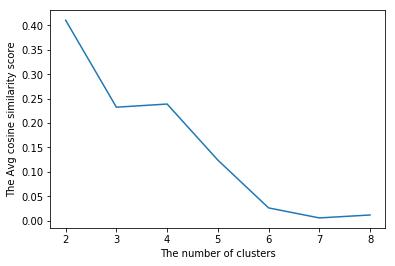

[(0, '0.171*"day" + 0.111*"help" + 0.042*"camp" + 0.038*"nepal" + 0.035*"ever" + 0.031*"quake" + 0.023*"base" + 0.021*"miss" + 0.011*"contact" + 0.010*"bury"'), (1, '0.196*"nepal" + 0.165*"kathmandu" + 0.098*"nepalearthquake" + 0.091*"earthquake" + 0.028*"still" + 0.021*"damage" + 0.020*"many" + 0.014*"donate" + 0.014*"destroy" + 0.013*"news"'), (2, '0.072*"alive" + 0.028*"need" + 0.026*"medical" + 0.023*"strand" + 0.022*"valley" + 0.021*"see" + 0.020*"building" + 0.020*"village" + 0.018*"gorkha" + 0.016*"katmandu"'), (3, '0.059*"old" + 0.043*"kathmandus" + 0.027*"world" + 0.026*"devastate" + 0.026*"today" + 0.025*"district" + 0.023*"rt" + 0.020*"site" + 0.020*"square" + 0.019*"come"'), (4, '0.113*"rubble" + 0.075*"rescue" + 0.062*"relief" + 0.057*"pull" + 0.051*"trap" + 0.049*"nepalquake" + 0.039*"boy" + 0.022*"baby" + 0.020*"aid" + 0.018*"nepalquakerelief"'), (5, '0.116*"people" + 0.105*"body" + 0.051*"collapse" + 0.042*"survivor" + 0.032*"build" + 0.031*"nepalese" + 0.029*"efforts_d

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      29.281668        1       1  0.300293 -0.031124
4      16.789474        1       2 -0.016666  0.393072
2      14.698024        1       3 -0.015108 -0.050259
0      12.918493        1       4  0.198441 -0.096670
3      10.210299        1       5 -0.208784 -0.109720
5       8.256293        1       6 -0.117615 -0.147626
6       7.845757        1       7 -0.140562  0.042327, topic_info=     Category          Freq                 Term         Total  loglift  \
term                                                                      
29    Default  12366.000000            kathmandu  12366.000000  30.0000   
40    Default  16022.000000                nepal  16022.000000  29.0000   
672   Default   5656.000000                  day   5656.000000  28.0000   
189   Default   7348.000000      nepalearthquake   7348.000000  27.0000   
36    Default   4842.000000               rubble   4842.000000  26.0000   
28    Default   6860.000000           earthquake   6860.000000  25.0000   
164   Default   3658.000000                 help   3658.000000  24.0000   
85    Default   2447.000000               people   2447.000000  23.0000   
631   Default   3214.000000               rescue   3214.000000  22.0000   
95    Default   2218.000000                 body   2218.000000  21.0000   
560   Default   2709.000000                alive   2709.000000  20.0000   
564   Default   2038.000000                woman   2038.000000  19.0000   
1448  Default   2653.000000               relief   2653.000000  18.0000   
1359  Default   2468.000000                 pull   2468.000000  17.0000   
37    Default   2200.000000                 trap   2200.000000  16.0000   
90    Default   2090.000000           nepalquake   2090.000000  15.0000   
148   Default   1544.000000                  old   1544.000000  14.0000   
575   Default   1383.000000                 tent   1383.000000  13.0000   
3340  Default   1321.000000                 food   1321.000000  12.0000   
1761  Default   1673.000000                  boy   1673.000000  11.0000   
464   Default   1382.000000                 camp   1382.000000  10.0000   
10    Default   1075.000000             collapse   1075.000000   9.0000   
661   Default   1048.000000                 city   1048.000000   8.0000   
260   Default   2122.000000                still   2122.000000   7.0000   
129   Default   1129.000000           kathmandus   1129.000000   6.0000   
93    Default   1166.000000                 ever   1166.000000   5.0000   
242   Default    889.000000             survivor    889.000000   4.0000   
105   Default   1840.000000                quake   1840.000000   3.0000   
401   Default   1036.000000                 need   1036.000000   2.0000   
254   Default    990.000000              medical    990.000000   1.0000   
...       ...           ...                  ...           ...      ...   
2975   Topic7    253.244995               supply    254.176117   2.5415   
635    Topic7    191.914810                 home    192.850861   2.5403   
3342   Topic7    163.344971               packet    164.277084   2.5395   
456    Topic7    155.322357                child    156.252701   2.5392   
3296   Topic7    160.141556               mother    161.194122   2.5386   
116    Topic7    135.057495                break    135.985352   2.5384   
246    Topic7    133.478287                 huge    134.407272   2.5383   
353    Topic7    131.854080        pashupatinath    132.782181   2.5382   
489    Topic7    130.550491                   pm    131.481277   2.5381   
3797   Topic7    129.699173                 want    130.648270   2.5379   
249    Topic7    124.975853              ancient    125.906029   2.5378   
62     Topic7    122.524223             hospital    123.451218   2.5377   
4601   Topic7    191.503326               ravage    193.033005   2.5372   
2699   Topic7    116.

In [71]:

K_lda=Mutiple_Times_LDA(all_data,[2,3,4,5,6,7,8])
plot=K_lda.runMutipleTimesLDA()
plot





# Test - Test whether can differentiate Nepal and Ebola datasets

In [41]:
Ebola_data=pd.read_csv("Clean_Ebola.csv")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


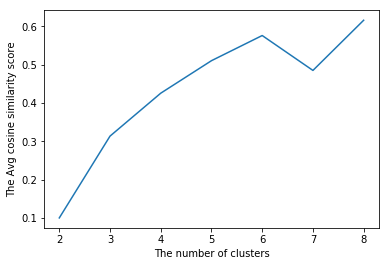

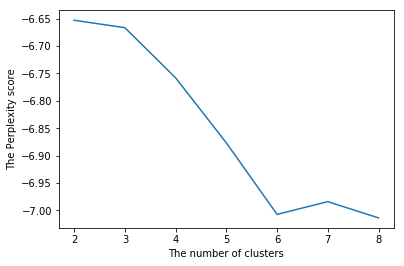

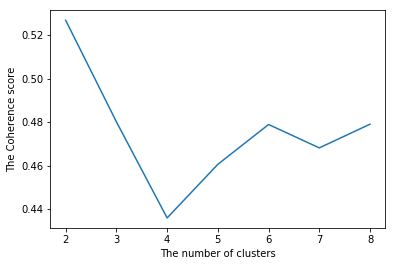

The 1 Topics Meanings are: nepal kathmandu earthquake avalanche ever 
The 2 Topics Meanings are: africa go west sierraleone virus 


PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
0      56.038071        1       1  0.103245  0.0
1      43.961933        1       2 -0.103245  0.0, topic_info=     Category       Freq             Term      Total  loglift  logprob
term                                                                  
4     Default  38.000000            nepal  38.000000  30.0000  30.0000
15    Default  27.000000        kathmandu  27.000000  29.0000  29.0000
57    Default  23.000000       earthquake  23.000000  28.0000  28.0000
466   Default   8.000000           africa   8.000000  27.0000  27.0000
32    Default  12.000000        avalanche  12.000000  26.0000  26.0000
33    Default  11.000000             ever  11.000000  25.0000  25.0000
5     Default   9.000000  nepalearthquake   9.000000  24.0000  24.0000
205   Default   6.000000               go   6.000000  23.0000  23.0000
465   Default   6.000000            virus   6.000000  22.0000  22.0000
36    Default   8.000000            quake   8.000000  21.0000  21.0000
11    Default   8.000000         collapse   8.000000  20.0000  20.0000
586   Default   5.000000                😂   5.000000  19.0000  19.0000
243   Default   6.000000             west   6.000000  18.0000  18.0000
94    Default   7.000000           rubble   7.000000  17.0000  17.0000
527   Default   4.000000           spread   4.000000  16.0000  16.0000
61    Default   6.000000            tower   6.000000  15.0000  15.0000
44    Default   6.000000           rescue   6.000000  14.0000  14.0000
46    Default   6.000000             trap   6.000000  13.0000  13.0000
498   Default   4.000000         monrovia   4.000000  12.0000  12.0000
557   Default   4.000000         outbreak   4.000000  11.0000  11.0000
462   Default   6.000000          senegal   6.000000  10.0000  10.0000
68    Default   5.000000         official   5.000000   9.0000   9.0000
170   Default   5.000000            still   5.000000   8.0000   8.0000
37    Default   5.000000          trigger   5.000000   7.0000   7.0000
74    Default   5.000000        base_camp   5.000000   6.0000   6.0000
253   Default   3.000000           friend   3.000000   5.0000   5.0000
270   Default   3.000000            world   3.000000   4.0000   4.0000
657   Default   3.000000                💪   3.000000   3.0000   3.0000
546   Default   3.000000             tell   3.000000   2.0000   2.0000
512   Default   3.000000           sierra   3.000000   1.0000   1.0000
...       ...        ...              ...        ...      ...      ...
512    Topic2   3.062814           sierra   3.438869   0.7060  -5.5199
511    Topic2   3.062712            leone   3.438899   0.7060  -5.5199
117    Topic2   2.629926             step   3.022902   0.6826  -5.6723
252    Topic2   2.433558              can   2.809321   0.6783  -5.7499
717    Topic2   2.370706            point   2.746441   0.6747  -5.7760
397    Topic2   2.370689              far   2.746445   0.6747  -5.7760
473    Topic2   2.370655             week   2.746455   0.6747  -5.7761
635    Topic2   2.370636            there   2.746460   0.6747  -5.7761
706    Topic2   2.370632             come   2.746461   0.6747  -5.7761
404    Topic2   2.370616             what   2.746466   0.6747  -5.7761
467    Topic2   2.370590          country   2.746473   0.6747  -5.7761
596    Topic2   2.370584           kebetu   2.746475   0.6747  -5.7761
514    Topic2   2.370545            speak   2.746485   0.6746  -5.7761
401    Topic2   2.370533             real   2.746489   0.6746  -5.7761
470    Topic2   2.370527            leave   2.746491   0.6746  -5.7761
528    Topic2   2.370495             stop   2.746500   0.6746  -5.7761
243    Topic2   5.832975             west   6.825169   0.6648  -4.8757
187    Topic2   2.160868            press   2.536615   0.6615  -5.8687
119    Topic2   1.931128              who   2.332338   0.6331  -5.9811
462    Topic2   5.140061          senegal   6.401295   0.6024  -5.002

In [36]:
nepal_data_1000=all_data.sample(n=100)
ebola_data_1000=Ebola_data.sample(n=100)

merged_data=pd.concat([nepal_data_1000,ebola_data_1000])
merged_LDA=Mutiple_Times_LDA(merged_data,[2,3,4,5,6,7,8],0.05)
plot=merged_LDA.runMutipleTimesLDA()
plot